In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


from neuralbridge.run_scripts.read_config import read_config
from neuralbridge.stochastic_processes.examples import (
    BrownianProcess, BrownianAuxProcess, BrownianBridgeProcess,
    OrnsteinUhlenbeckProcess, OrnsteinUhlenbeckAuxProcess, OrnsteinUhlenbeckBridgeProcess
)
from neuralbridge.models.neurb import NeuralBridge
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.mlps import MLPSmall
from neuralbridge.utils.plotting import plot_sample_path, plot_sample_path_histogram

### Brownian bridges

In [3]:
config = read_config("../configs/brownian.yaml")
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)

W = WienerProcess(
    T=config.sde.T,
    dt=config.sde.dt,
    shape=(config.sde.dim, )
)

# gamma = 1.0
config.sde.params_X["gamma"] = 1.0
config.training.save_name = "brownian_bridge_1.0gamma"
print(config)
X_1 = BrownianProcess(
    params=config.sde.params_X,
    T=config.sde.T,
    dim=config.sde.dim
)
X_tilde_1 = BrownianAuxProcess(
    params=config.sde.params_X_tilde,
    T=config.sde.T,
    dim=config.sde.dim
)
X_star_1 = BrownianBridgeProcess(
    params=config.sde.params_X,
    v=v,
    T=config.sde.T,
    dim=config.sde.dim
)
X_circ_1 = GuidedBridgeProcess(
    X=X_1,
    X_tilde=X_tilde_1,
    u=u,
    v=v,
    eps=config.sde.eps,
    ts=jnp.arange(0, config.sde.T + config.sde.dt, config.sde.dt)
)
X_diamond_1 = NeuralBridge(
    X_circ=X_circ_1,
    config=config
)
X_diamond_1.initialize_solver(W)
losses_1 = X_diamond_1.train(mode="pretrained", load_relative_dir="../assets/ckpts/neural_bridge/")
X_diamond_1_path = X_diamond_1.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=8)

# gamma = 2.0
config.sde.params_X["gamma"] = 2.0
config.training.save_name = "brownian_bridge_2.0gamma"
print(config)
X_2 = BrownianProcess(
    params=config.sde.params_X,
    T=config.sde.T,
    dim=config.sde.dim
)
X_tilde_2 = BrownianAuxProcess(
    params=config.sde.params_X_tilde,
    T=config.sde.T,
    dim=config.sde.dim
)
X_star_2 = BrownianBridgeProcess(
    params=config.sde.params_X,
    v=v,
    T=config.sde.T,
    dim=config.sde.dim
)
X_circ_2 = GuidedBridgeProcess(
    X=X_2,
    X_tilde=X_tilde_2,
    u=u,
    v=v,
    eps=config.sde.eps,
    ts=jnp.arange(0, config.sde.T + config.sde.dt, config.sde.dt)
)
X_diamond_2 = NeuralBridge(
    X_circ=X_circ_2,
    config=config
)
X_diamond_2.initialize_solver(W)
losses_2 = X_diamond_2.train(mode="pretrained", load_relative_dir="../assets/ckpts/neural_bridge/")
X_diamond_2_path = X_diamond_2.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=8)
# gamma = 5.0
config.sde.params_X["gamma"] = 5.0
config.training.save_name = "brownian_bridge_5.0gamma"
print(config)
X_5 = BrownianProcess(
    params=config.sde.params_X,
    T=config.sde.T,
    dim=config.sde.dim
)
X_tilde_5 = BrownianAuxProcess(
    params=config.sde.params_X_tilde,
    T=config.sde.T,
    dim=config.sde.dim
)
X_star_5 = BrownianBridgeProcess(
    params=config.sde.params_X,
    v=v,
    T=config.sde.T,
    dim=config.sde.dim
)
X_circ_5 = GuidedBridgeProcess(
    X=X_5,
    X_tilde=X_tilde_5,
    u=u,
    v=v,
    eps=config.sde.eps,
    ts=jnp.arange(0, config.sde.T + config.sde.dt, config.sde.dt)
)
X_diamond_5 = NeuralBridge(
    X_circ=X_circ_5,
    config=config
)
X_diamond_5.initialize_solver(W)
losses_5 = X_diamond_5.train(mode="pretrained", load_relative_dir="../assets/ckpts/neural_bridge/")
X_diamond_5_path = X_diamond_5.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=8)

# gamma = 10.0
config.sde.params_X["gamma"] = 10.0
config.training.save_name = "brownian_bridge_10.0gamma"
print(config)
X_10 = BrownianProcess(
    params=config.sde.params_X,
    T=config.sde.T,
    dim=config.sde.dim
)
X_tilde_10 = BrownianAuxProcess(
    params=config.sde.params_X_tilde,
    T=config.sde.T,
    dim=config.sde.dim
)
X_star_10 = BrownianBridgeProcess(
    params=config.sde.params_X,
    v=v,
    T=config.sde.T,
    dim=config.sde.dim
)
X_circ_10 = GuidedBridgeProcess(
    X=X_10,
    X_tilde=X_tilde_10,
    u=u,
    v=v,
    eps=config.sde.eps,
    ts=jnp.arange(0, config.sde.T + config.sde.dt, config.sde.dt)
)
X_diamond_10 = NeuralBridge(
    X_circ=X_circ_10,
    config=config
)
X_diamond_10.initialize_solver(W)
losses_10 = X_diamond_10.train(mode="pretrained", load_relative_dir="../assets/ckpts/neural_bridge/")
X_diamond_10_path = X_diamond_10.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=8)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


{'sde': {'dim': 1, 'T': 1.0, 'dt': 0.005, 'params_X': {'gamma': 1.0, 'sigma': 1.0}, 'params_X_tilde': {'gamma': 0.0, 'sigma': 1.0}, 'u': [0.0], 'v': [0.0], 'eps': 1e-08}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 1, 'hidden_dims': [20, 20, 20], 'activation': 'tanh'}, 'training': {'save_name': 'brownian_bridge_1.0gamma', 'learning_rate': 0.001, 'batch_size': 64, 'n_iters': 500, 'n_epochs': 10, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps': 500, 'clip_norm': None}}


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neural_bridge/brownian_bridge_1.0gamma
INFO:root:Loading pretrained model from the last epoch
/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to readi

{'sde': {'dim': 1, 'T': 1.0, 'dt': 0.005, 'params_X': {'gamma': 2.0, 'sigma': 1.0}, 'params_X_tilde': {'gamma': 0.0, 'sigma': 1.0}, 'u': [0.0], 'v': [0.0], 'eps': 1e-08}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 1, 'hidden_dims': [20, 20, 20], 'activation': 'tanh'}, 'training': {'save_name': 'brownian_bridge_2.0gamma', 'learning_rate': 0.001, 'batch_size': 64, 'n_iters': 500, 'n_epochs': 10, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps': 500, 'clip_norm': None}}


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neural_bridge/brownian_bridge_5.0gamma
INFO:root:Loading pretrained model from the last epoch


{'sde': {'dim': 1, 'T': 1.0, 'dt': 0.005, 'params_X': {'gamma': 5.0, 'sigma': 1.0}, 'params_X_tilde': {'gamma': 0.0, 'sigma': 1.0}, 'u': [0.0], 'v': [0.0], 'eps': 1e-08}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 1, 'hidden_dims': [20, 20, 20], 'activation': 'tanh'}, 'training': {'save_name': 'brownian_bridge_5.0gamma', 'learning_rate': 0.001, 'batch_size': 64, 'n_iters': 500, 'n_epochs': 10, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps': 500, 'clip_norm': None}}


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neural_bridge/brownian_bridge_10.0gamma
INFO:root:Loading pretrained model from the last epoch


{'sde': {'dim': 1, 'T': 1.0, 'dt': 0.005, 'params_X': {'gamma': 10.0, 'sigma': 1.0}, 'params_X_tilde': {'gamma': 0.0, 'sigma': 1.0}, 'u': [0.0], 'v': [0.0], 'eps': 1e-08}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 1, 'hidden_dims': [20, 20, 20], 'activation': 'tanh'}, 'training': {'save_name': 'brownian_bridge_10.0gamma', 'learning_rate': 0.001, 'batch_size': 64, 'n_iters': 500, 'n_epochs': 10, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps': 500, 'clip_norm': None}}


In [4]:
optimal_loss_fn = lambda gamma, sigma: gamma**2 / (2 * sigma ** 2)
optimal_nu_fn = lambda gamma, sigma: - gamma / sigma

gammas = [1.0, 2.0, 5.0, 10.0]
sigmas = [1.0, 1.0, 1.0, 1.0]
optimal_losses = [optimal_loss_fn(gamma, sigma) for gamma, sigma in zip(gammas, sigmas)]
optimal_nus = [optimal_nu_fn(gamma, sigma) for gamma, sigma in zip(gammas, sigmas)]
for gamma, sigma, optimal_loss, optimal_nu in zip(gammas, sigmas, optimal_losses, optimal_nus):
    print(f"gamma = {gamma}, sigma = {sigma}")
    print(f"Optimal loss: {optimal_loss}")
    print(f"Optimal nu: {optimal_nu}")
    print("-" * 50)

gamma = 1.0, sigma = 1.0
Optimal loss: 0.5
Optimal nu: -1.0
--------------------------------------------------
gamma = 2.0, sigma = 1.0
Optimal loss: 2.0
Optimal nu: -2.0
--------------------------------------------------
gamma = 5.0, sigma = 1.0
Optimal loss: 12.5
Optimal nu: -5.0
--------------------------------------------------
gamma = 10.0, sigma = 1.0
Optimal loss: 50.0
Optimal nu: -10.0
--------------------------------------------------


In [8]:
X_star_solver = Euler(X_star_1, W) # Bridge process is independent of gamma, therefore choose any one
X_star_path = X_star_solver.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=8)

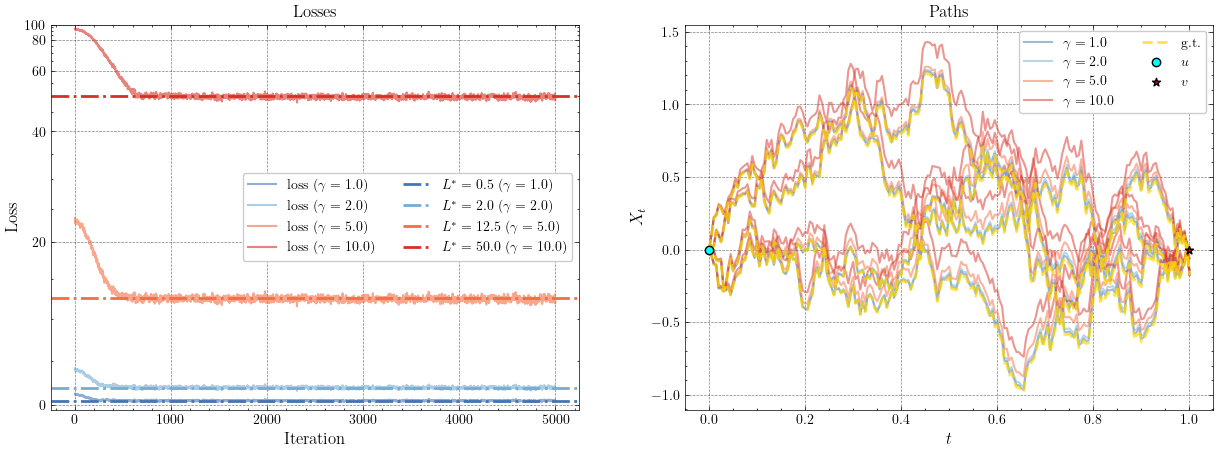

In [25]:
# Losses
def smooth(values, weight=0.7):
    smoothed = []
    last = values[0]
    for value in values:
        smoothed_value = last * weight + (1 - weight) * value
        smoothed.append(smoothed_value)
        last = smoothed_value
    return smoothed

def inverse(a):
    # Adjust the scale factor to control the "spread" of the transformation
    scale = 2.0  # Try values between 0.05 and 0.5
    a = scale * jnp.deg2rad(a)
    return jnp.rad2deg(jnp.log(jnp.abs(jnp.tan(a) + 1.0 / jnp.cos(a)))) / scale

def forward(a):
    scale = 2.0  # Use the same scale factor as in forward
    a = scale * jnp.deg2rad(a)
    return jnp.rad2deg(jnp.arctan(jnp.sinh(a))) / scale

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# Plot loss curves with increasing gamma values
axes[0].plot(smooth(losses_1), color='#4575b4', alpha=0.6, label=r"loss ($\gamma = 1.0$)", linewidth=1.5)
axes[0].plot(smooth(losses_2), color='#74add1', alpha=0.6, label=r"loss ($\gamma = 2.0$)", linewidth=1.5)
axes[0].plot(smooth(losses_5), color='#f46d43', alpha=0.6, label=r"loss ($\gamma = 5.0$)", linewidth=1.5)
axes[0].plot(smooth(losses_10), color='#d73027', alpha=0.6, label=r"loss ($\gamma = 10.0$)", linewidth=1.5)

# Plot optimal loss lines with increased visibility
axes[0].axhline(y=optimal_losses[0], color='#4575b4', linestyle='dashdot', linewidth=2.0,
                label=fr'$L^*={optimal_losses[0]:.1f}$ $(\gamma = 1.0)$')
axes[0].axhline(y=optimal_losses[1], color='#74add1', linestyle='dashdot', linewidth=2.0,
                label=fr'$L^*={optimal_losses[1]:.1f}$ $(\gamma = 2.0)$')
axes[0].axhline(y=optimal_losses[2], color='#f46d43', linestyle='dashdot', linewidth=2.0,
                label=fr'$L^*={optimal_losses[2]:.1f}$ $(\gamma = 5.0)$')
axes[0].axhline(y=optimal_losses[3], color='#d73027', linestyle='dashdot', linewidth=2.0,
                label=fr'$L^*={optimal_losses[3]:.1f}$ $(\gamma = 10.0)$')
axes[0].set_xlabel(r"Iteration", fontsize=12)
axes[0].set_ylabel(r"Loss", fontsize=12)
axes[0].set_yscale("function", functions=(forward, inverse))
axes[0].set_ylim(-0.5, 100.0)
axes[0].legend(ncol=2)
axes[0].set_title(r"Losses")

plot_sample_path(X_diamond_1_path[:4], ax=axes[1], colors='#4575b4', label=r"$\gamma = 1.0$", linewidth=1.5, zorder=1, alpha=0.5)
plot_sample_path(X_diamond_2_path[:4], ax=axes[1], colors='#74add1', label=r"$\gamma = 2.0$", linewidth=1.5, zorder=1, alpha=0.5)
plot_sample_path(X_diamond_5_path[:4], ax=axes[1], colors='#f46d43', label=r"$\gamma = 5.0$", linewidth=1.5, zorder=1, alpha=0.5)
plot_sample_path(X_diamond_10_path[:4], ax=axes[1], colors='#d73027', label=r"$\gamma = 10.0$", linewidth=1.5, zorder=1, alpha=0.5)
plot_sample_path(X_star_path[:4], ax=axes[1], colors="gold", label="g.t.", linewidth=2.0, zorder=2, linestyle="--")
axes[1].scatter(0.0, 0.0, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
axes[1].scatter(1.0, 0.0, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)

axes[1].legend(ncol=2)
axes[1].set_xlabel(r"$t$", fontsize=12)
axes[1].set_ylabel(r"$X_t$", fontsize=12)
axes[1].set_title(r"Paths")

fig.savefig("../assets/figures/brownian/losses_and_paths.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [26]:
# Error
nu_1 = lambda t, x: partial(X_diamond_1.X_diamond.nu, variables={"params": X_diamond_1.state.params})(t, x)
nu_2 = lambda t, x: partial(X_diamond_2.X_diamond.nu, variables={"params": X_diamond_2.state.params})(t, x)
nu_5 = lambda t, x: partial(X_diamond_5.X_diamond.nu, variables={"params": X_diamond_5.state.params})(t, x)
nu_10 = lambda t, x: partial(X_diamond_10.X_diamond.nu, variables={"params": X_diamond_10.state.params})(t, x)
t_res, x_res = 50, 50
t_vals = jnp.linspace(0, 1, t_res)
x_vals = jnp.linspace(-1.5, 1.5, x_res)
t_grid, x_grid = jnp.meshgrid(t_vals, x_vals)
tx_pairs = jnp.stack([t_grid.flatten(), x_grid.flatten()], axis=1)
outs_1 = jax.vmap(nu_1)(tx_pairs[:, 0], tx_pairs[:, 1:]).reshape(t_res, x_res)
outs_2 = jax.vmap(nu_2)(tx_pairs[:, 0], tx_pairs[:, 1:]).reshape(t_res, x_res)
outs_5 = jax.vmap(nu_5)(tx_pairs[:, 0], tx_pairs[:, 1:]).reshape(t_res, x_res)
outs_10 = jax.vmap(nu_10)(tx_pairs[:, 0], tx_pairs[:, 1:]).reshape(t_res, x_res)

errors_1 = outs_1 - optimal_nus[0]
errors_2 = outs_2 - optimal_nus[1]
errors_5 = outs_5 - optimal_nus[2]
errors_10 = outs_10 - optimal_nus[3]

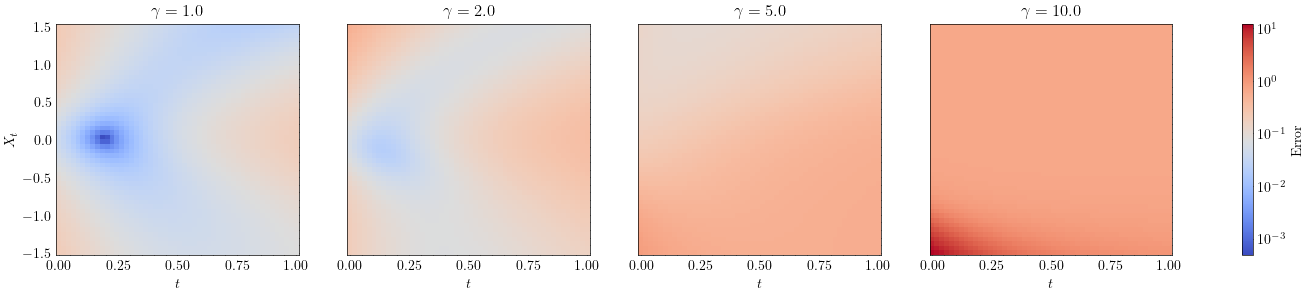

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(18, 3), sharey=True)

# Find global min/max for consistent colorbar
vmin = min(errors_1.min(), errors_2.min(), errors_5.min(), errors_10.min())
vmax = max(errors_1.max(), errors_2.max(), errors_5.max(), errors_10.max())

# Use absolute values and log scale for better visualization
from matplotlib.colors import SymLogNorm
norm = SymLogNorm(linthresh=1e-3, vmin=vmin, vmax=vmax)

im = ax[0].pcolormesh(t_vals, x_vals, errors_1, cmap="coolwarm", shading='auto', norm=norm)
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$X_t$")
ax[0].set_title(r"$\gamma = 1.0$")
ax[0].minorticks_on()

ax[1].pcolormesh(t_vals, x_vals, errors_2, cmap="coolwarm", shading='auto', norm=norm)
ax[1].set_xlabel(r"$t$")
ax[1].set_title(r"$\gamma = 2.0$")
ax[1].minorticks_on()

ax[2].pcolormesh(t_vals, x_vals, errors_5, cmap="coolwarm", shading='auto', norm=norm)
ax[2].set_xlabel(r"$t$")
ax[2].set_title(r"$\gamma = 5.0$")
ax[2].minorticks_on()

ax[3].pcolormesh(t_vals, x_vals, errors_10, cmap="coolwarm", shading='auto', norm=norm)
ax[3].set_xlabel(r"$t$")
ax[3].set_title(r"$\gamma = 10.0$")
ax[3].minorticks_on()

# Add single colorbar on the right with log scale
plt.colorbar(im, ax=ax.ravel().tolist(), label="Error")
fig.savefig("../assets/figures/brownian/errors.pdf", dpi=300, bbox_inches="tight")
plt.show()

### OU Bridges

In [70]:
config = read_config("../configs/ou.yaml")
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)
print(config)

W = WienerProcess(
    T=config.sde.T,
    dt=config.sde.dt,
    shape=(config.sde.dim, )
)

X = OrnsteinUhlenbeckProcess(
    params=config.sde.params_X,
    T=config.sde.T,
    dim=config.sde.dim
)
X_tilde = OrnsteinUhlenbeckAuxProcess(
    params=config.sde.params_X_tilde,
    T=config.sde.T,
    dim=config.sde.dim
)
X_star = OrnsteinUhlenbeckBridgeProcess(
    params=config.sde.params_X,
    v=v,
    T=config.sde.T,
    dim=config.sde.dim
)
X_circ = GuidedBridgeProcess(
    X=X,
    X_tilde=X_tilde,
    u=u,
    v=v,
    eps=config.sde.eps,
    ts=jnp.arange(0, config.sde.T + config.sde.dt, config.sde.dt)
)
X_diamond = NeuralBridge(
    X_circ=X_circ,
    config=config
)
X_diamond.initialize_solver(W)
losses = X_diamond.train(mode="pretrained", load_relative_dir="../assets/ckpts/neural_bridge/")
X_diamond_path = X_diamond.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=8)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neural_bridge/ou_bridge_gamma2.0
INFO:root:Loading pretrained model from the last epoch


{'sde': {'dim': 1, 'T': 1.0, 'dt': 0.005, 'params_X': {'gamma': 2.0, 'sigma': 1.0}, 'params_X_tilde': {'gamma': 0.0, 'sigma': 1.0}, 'u': [0.0], 'v': [1.0], 'eps': 1e-08}, 'network': {'mlp_type': 'mlp_small', 'out_dim': 1, 'hidden_dims': [20, 20, 20], 'activation': 'tanh'}, 'training': {'save_name': 'ou_bridge_gamma2.0', 'learning_rate': 0.001, 'batch_size': 64, 'n_iters': 500, 'n_epochs': 10, 'ema_decay': 0.995, 'optimizer': 'adam', 'warmup_steps': 500, 'clip_norm': None}}


In [96]:
optimal_nu_fn = lambda t, x, gamma, sigma: (- gamma * (v / jnp.sinh(-gamma * (config.sde.T - t)) - x / jnp.tanh(-gamma * (config.sde.T - t))) + gamma * x - (v - x) / (config.sde.T - t)) / sigma

In [83]:
X_star_solver = Euler(X_star, W)
X_star_path = X_star_solver.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=8)

In [125]:
t_res, x_res = 50, 50
t_vals = jnp.linspace(0, 1, t_res, endpoint=False)
x_vals = jnp.linspace(-0.75, 1.35, x_res)
t_grid, x_grid = jnp.meshgrid(t_vals, x_vals)
tx_pairs = jnp.stack([t_grid.flatten(), x_grid.flatten()], axis=1)
outs = jax.vmap(
    lambda t, x: partial(X_diamond.X_diamond.nu, variables={"params": X_diamond.state.params})(t, x)
)(tx_pairs[:, 0], tx_pairs[:, 1:]).reshape(t_res, x_res)
optimal_outs = jax.vmap(
    lambda t, x: optimal_nu_fn(t, x, config.sde.params_X.gamma, config.sde.params_X.sigma)
)(tx_pairs[:, 0], tx_pairs[:, 1]).reshape(t_res, x_res)
errors = outs - optimal_outs

In [126]:
X_diamond_path_many = X_diamond.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=1000)
X_star_path_many = X_star_solver.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=1000)

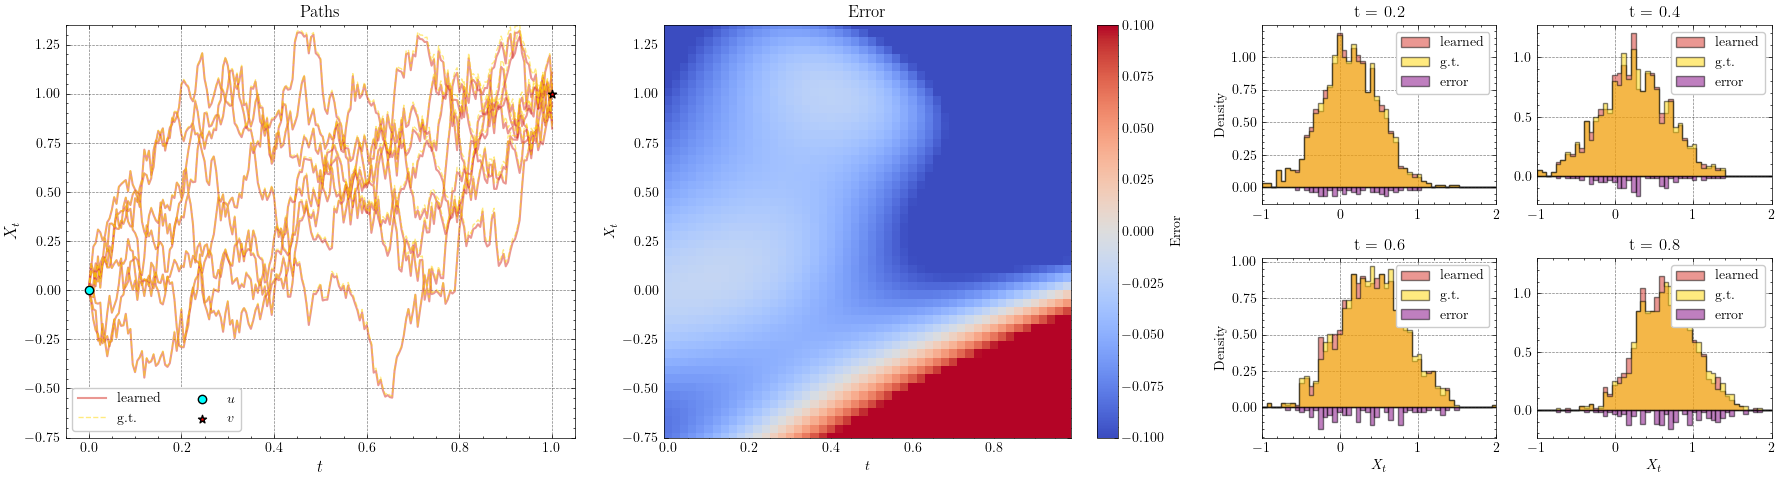

In [140]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
plot_sample_path(X_diamond_path, ax=ax[0], colors='#d73027', label="learned", linewidth=1.5, alpha=0.5)
plot_sample_path(X_star_path, ax=ax[0], colors="gold", label="g.t.", linewidth=1.0, linestyle="--", alpha=0.5)
ax[0].scatter(0.0, 0.0, color="cyan", marker="o", edgecolor="black", linewidth=1.0, label=r"$u$", zorder=3)
ax[0].scatter(1.0, 1.0, color="red", marker="*", edgecolor="black", linewidth=1.0, label=r"$v$", zorder=3)
ax[0].legend(ncol=2)
ax[0].set_xlabel(r"$t$", fontsize=12)
ax[0].set_ylabel(r"$X_t$", fontsize=12)
ax[0].set_title(r"Paths")
ax[0].set_ylim(-0.75, 1.35)
ax[0].minorticks_on()

norm = plt.Normalize(vmin=-0.1, vmax=0.1)
im = ax[1].pcolormesh(t_vals, x_vals, errors, cmap="coolwarm", shading='auto', norm=norm)
ax[1].set_xlabel(r"$t$")
ax[1].set_ylabel(r"$X_t$")
ax[1].set_title(r"Error")
ax[1].minorticks_on()
plt.colorbar(im, ax=ax[1], label="Error")
# ax[1].set_ylim(-0.75, 1.35)
ax[1].sharey(ax[0])

ax[2].set_visible(False)

from matplotlib import gridspec
import numpy as np
gs = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=ax[2].get_subplotspec())

t_slices = [0.2, 0.4, 0.6, 0.8]

for i, t_slice in enumerate(t_slices):
    t_idx = int(t_slice // config.sde.dt)
    curr_ax = fig.add_subplot(gs[i//2, i%2])
    # Plot distributions
    curr_ax.hist(X_diamond_path_many.xs[:, t_idx, 0], bins=50, density=True, range=(-1.0, 2.0), 
                 color='#d73027', alpha=0.5, label="learned", histtype='stepfilled', edgecolor='black')
    curr_ax.hist(X_star_path_many.xs[:, t_idx, 0], bins=50, density=True, range=(-1.0, 2.0),
                 color='gold', alpha=0.5, label="g.t.", histtype='stepfilled', edgecolor='black')
    curr_ax.set_title(f"t = {t_slice:.1f}")
    
    # Plot errors histogram below
    # Calculate histograms for both distributions
    learned_hist, _ = np.histogram(X_diamond_path_many.xs[:, t_idx, 0], bins=50, density=True, range=(-1.0, 2.0))
    gt_hist, bin_edges = np.histogram(X_star_path_many.xs[:, t_idx, 0], bins=50, density=True, range=(-1.0, 2.0))
    
    # Calculate error between the histograms
    binned_errors = -np.abs(learned_hist - gt_hist)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Plot the binned errors
    curr_ax.bar(bin_centers, binned_errors, width=np.diff(bin_edges),
                color='purple', alpha=0.5, label="error",
                bottom=0.0, edgecolor='black')
    curr_ax.set_xlim(-1.0, 2.0)
    curr_ax.legend(loc='upper right')
    
    if i >= 2:
        curr_ax.set_xlabel(r"$X_t$")
    if i % 2 == 0:
        curr_ax.set_ylabel("Density")
        
    # Add spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()

fig.savefig("../assets/figures/ou/results.pdf", dpi=300, bbox_inches="tight")
plt.show()

(0.0, 1.0)

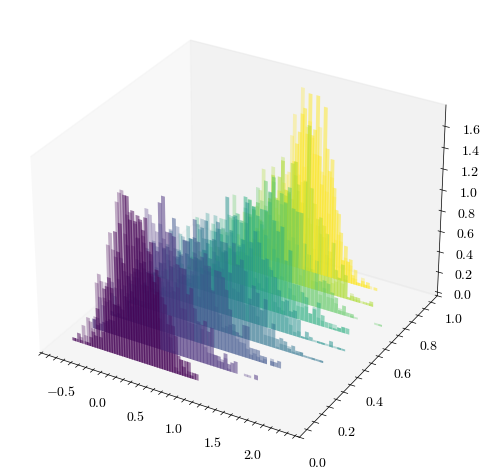

In [153]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

y_ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = plt.cm.viridis(np.linspace(0, 1, len(y_ticks)))

for c, k in zip(colors, y_ticks):
    # Find the index corresponding to time k*T
    t_idx = jnp.argmin(jnp.abs(ts - k*T))
    
    # Get samples at this time point
    diamond_samples = X_diamond_xs[:, t_idx, 0]
    star_samples = X_star_xs[:, t_idx, 0]
    
    # Create histogram for both processes at this time slice
    hist_diamond, bins = np.histogram(diamond_samples, bins=50, density=True)
    hist_star, _ = np.histogram(star_samples, bins=bins, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Plot histograms on the corresponding plane
    zs = k * np.ones_like(bin_centers)
    ax.bar(bin_centers, hist_diamond, zs=zs, zdir='y', color=c, alpha=0.5, width=0.05, fill=True)
    ax.bar(bin_centers, hist_star, zs=zs, zdir='y', color=c, alpha=0.3, width=0.05, fill=True)
    
ax.grid(False)
ax.set_ylim(0.0, 1.0)
